# D. State stabilization in a noisy environment with Jaynes-Cummings controls

In [17]:
# ruff: noqa
import os

#os.sys.path.append("../../../..")
os.sys.path.append("./../feedback-grape")

### Code copied from Yousef's thesis. This code is not identical to example D on readthedocs.io or in the fgrape library

In [18]:
from feedback_grape.fgrape import optimize_pulse
from feedback_grape.utils.operators import (
    sigmap,
    sigmam,
    create,
    destroy,
    identity,
    cosm,
    sinm,
)
from feedback_grape.utils.states import basis, fock
from feedback_grape.utils.tensor import tensor
from feedback_grape.utils.operators import create, destroy
import jax.numpy as jnp
import jax
from jax.scipy.linalg import expm

N_cav = 20
# initial state is a thermal state coupled to a qubit in the ground state?
n_average = 1
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cav))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)
rho0 = tensor(rho_cav, basis(2, 0) @ basis(2, 0).conj().T)

psi_target = tensor(
    (fock(N_cav, 1) + fock(N_cav, 2) + fock(N_cav, 3)) / jnp.sqrt(3), basis(2)
)
psi_target = psi_target / jnp.linalg.norm(psi_target)
rho_target = psi_target @ psi_target.conj().T

def povm_measure_operator(measurement_outcome, params):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    gamma, delta = params
    number_operator = tensor(create(N_cav) @ destroy(N_cav), identity(2))
    angle = (gamma * number_operator) + delta / 2
    meas_op = jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )
    return meas_op

# same as implementation in other examples
def qubit_unitary(alphas):
    alpha_re, alpha_im = alphas
    alpha = alpha_re + 1j * alpha_im
    return tensor(
    identity(N_cav),
    expm(-1j * (alpha * sigmap() + alpha.conjugate() * sigmam()) / 2),
)
def qubit_cavity_unitary(betas):
    beta_re, beta_im = betas
    beta = beta_re + 1j * beta_im
    return expm(
    -1j
    * (
    beta * (tensor(destroy(N_cav), sigmap()))
    + beta.conjugate() * (tensor(create(N_cav), sigmam()))
    )
    / 2
)

In [19]:
key1, key2, key3 = jax.random.split(jax.random.PRNGKey(42), 3)
measure = Gate(
    gate=povm_measure_operator,
    initial_params=jax.random.uniform(
        key1,
        shape=(2,), # 2 for gamma and delta
        minval=-2 * jnp.pi,
        maxval=2 * jnp.pi,
    ),
    measurement_flag=True,
)
qub_unitary = Gate(
    gate=qubit_unitary,
    initial_params=jax.random.uniform(
        key2,
        shape=(2,), # 2 for gamma and delta
        minval=-2 * jnp.pi,
        maxval=2 * jnp.pi,
    ),
    measurement_flag=False,
)
qub_cav = Gate(
gate=qubit_cavity_unitary,
    initial_params=jax.random.uniform(
        key3,
        shape=(2,), # 2 for gamma and delta
        minval=-2 * jnp.pi,
        maxval=2 * jnp.pi,
    ),
    measurement_flag=False,
    )
system_params = [measure, qub_unitary, qub_cav]

### With Dissipation

In [20]:
# Note if tsave = jnp.linspace(0, 1, 1) = [0.0] then the decay is not applied ?
# because the first time step has the original non decayed state
# Question: Here I should not use any sort of Hamiltonian or tspan or something?
num_time_steps = 5
num_of_iterations = 1000
learning_rate = 0.02
result = optimize_pulse(
    U_0=rho0,
    C_target=rho_target,
    system_params=system_params,
    num_time_steps=num_time_steps,
    mode="lookup",
    goal="fidelity",
    max_iter=num_of_iterations,
    convergence_threshold=1e-6,
    learning_rate=learning_rate,
    evo_type="density",
    batch_size=10,
)

2025-10-04 14:36:26.065355: E external/xla/xla/service/slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-10-04 14:37:28.078691: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 3m2.015141s

********************************
[Compiling module jit_step] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [21]:
print(result.final_fidelity)

0.8941443638691023


In [22]:
from feedback_grape.utils.fidelity import fidelity

print(
    "initial fidelity:",
    fidelity(C_target=rho_target, U_final=rho_target, evo_type="density"),
)
for i, state in enumerate(result.final_state):
    print(
        f"fidelity of state {i}:",
        fidelity(C_target=rho_target, U_final=state, evo_type="density"),
    )

initial fidelity: 0.9999999999999998
fidelity of state 0: 0.7367146069217457
fidelity of state 1: 0.9812292203578734
fidelity of state 2: 0.9392403569468494
fidelity of state 3: 0.8706946937983159
fidelity of state 4: 0.7367146069217457
fidelity of state 5: 0.8359109991350477
fidelity of state 6: 0.9812292203578734
fidelity of state 7: 0.9392403569468494
fidelity of state 8: 0.9392403569468494
fidelity of state 9: 0.9812292203578734


In [23]:
result.returned_params

[[Array([[-4.71895968,  0.00786619],
         [-4.71895968,  0.00786619],
         [-4.71895968,  0.00786619],
         [-4.71895968,  0.00786619],
         [-4.71895968,  0.00786619],
         [-4.71895968,  0.00786619],
         [-4.71895968,  0.00786619],
         [-4.71895968,  0.00786619],
         [-4.71895968,  0.00786619],
         [-4.71895968,  0.00786619]], dtype=float64),
  Array([[0.26628386, 2.28535749],
         [3.08872086, 0.53234291],
         [0.26628386, 2.28535749],
         [3.08872086, 0.53234291],
         [0.26628386, 2.28535749],
         [3.08872086, 0.53234291],
         [3.08872086, 0.53234291],
         [0.26628386, 2.28535749],
         [0.26628386, 2.28535749],
         [3.08872086, 0.53234291]], dtype=float64),
  Array([[-1.89416644,  3.41749821],
         [-1.29979158,  1.73414231],
         [-1.89416644,  3.41749821],
         [-1.29979158,  1.73414231],
         [-1.89416644,  3.41749821],
         [-1.29979158,  1.73414231],
         [-1.29979158,  

In [24]:
result.optimized_trainable_parameters["initial_params"]

[Array([-4.71895968,  0.00786619], dtype=float64),
 Array([3.04255722, 0.59257698], dtype=float64),
 Array([-1.58503058,  2.06652483], dtype=float64)]

### Evaluate performance of optimized architecture on longer time span

In [28]:
from feedback_grape.fgrape import evaluate_on_longer_time

result_long = evaluate_on_longer_time(
    U_0 = rho0,
    C_target = rho_target,
    system_params = system_params,
    optimized_trainable_parameters = result.optimized_trainable_parameters,
    num_time_steps = 100,
    evo_type = "density",
    goal = "fidelity",
    mode = "lookup",
    rnn = None,
    eval_batch_size = 10,
    rnn_hidden_size = 30,
)

fidelities_long = result_long.fidelity_each_timestep

Text(0, 0.5, 'fidelity')

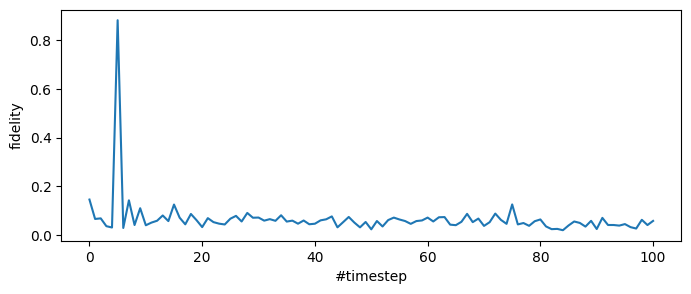

In [29]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(fidelities_long)
ax.set_xlabel("#timestep")
ax.set_ylabel("fidelity")

### Try again with uniform reward weights

In [30]:
# Note if tsave = jnp.linspace(0, 1, 1) = [0.0] then the decay is not applied ?
# because the first time step has the original non decayed state
# Question: Here I should not use any sort of Hamiltonian or tspan or something?
num_time_steps = 5
num_of_iterations = 1000
learning_rate = 0.02
result = optimize_pulse(
    U_0=rho0,
    C_target=rho_target,
    system_params=system_params,
    num_time_steps=num_time_steps,
    reward_weights = [1]*num_time_steps,
    mode="lookup",
    goal="fidelity",
    max_iter=num_of_iterations,
    convergence_threshold=1e-6,
    learning_rate=learning_rate,
    evo_type="density",
    batch_size=10,
)

In [33]:
from feedback_grape.fgrape import evaluate_on_longer_time

result_long_2 = evaluate_on_longer_time(
    U_0 = rho0,
    C_target = rho_target,
    system_params = system_params,
    optimized_trainable_parameters = result.optimized_trainable_parameters,
    num_time_steps = 100,
    evo_type = "density",
    goal = "fidelity",
    mode = "lookup",
    eval_batch_size=10,
    rnn=None,
    rnn_hidden_size=30,
)

fidelities_long_2 = result_long_2.fidelity_each_timestep

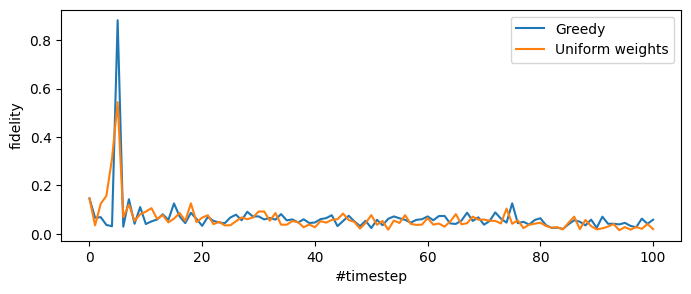

In [36]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(fidelities_long, label="Greedy")
ax.plot(fidelities_long_2, label="Uniform weights")
ax.set_xlabel("#timestep")
ax.set_ylabel("fidelity")
ax.legend()
fig.savefig("example_D_evaluation.png")